In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from triangle import triangulate, plot as tplot, convex_hull, show_data, get_data
from random import choice, sample
import matplotlib.colors as mcolors
import dill

In [2]:
F = dill.load(open('./calculations/poisson_quad', 'rb'))

In [3]:
t = np.linspace(0, 2*np.pi, 50, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T
seg = np.array([[j, j+1] for j in range(points.shape[0]-1)] + [[points.shape[0] - 1, 0]])

In [4]:
cndt = triangulate({'vertices':points, 'segments':seg}, opts='Rpq1a0.01neo2')

In [5]:
points = cndt['vertices']
triangles = cndt['triangles']
neighbours = cndt['neighbors']
triangles_s = points[triangles]
triangles_c = triangles_s.reshape(-1, 2)
vertice_maker_is_boundary = cndt["vertex_markers"]
print(f"Total number of points {points.shape[0]}")

Total number of points 995


In [ ]:
all_colors = list(mcolors.CSS4_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
colors = sample(all_colors, triangles_s.shape[0])

%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('equal')

for index, triangle in enumerate(triangles_s[:]):
    t1 = plt.Polygon(triangle[:3], color=colors[index])
    fig.gca().add_patch(t1)
    
    x, y = triangle.mean(axis=0)

for idx, point in enumerate(points):
    ax.scatter(point[0], point[1], color='black')

ax.set_xlim([points[:, 0].min(), points[:, 0].max()])
ax.set_ylim([points[:, 1].min(), points[:, 1].max()])

fig.tight_layout()
plt.show()

In [6]:
matrix = np.zeros((points.shape[0], points.shape[0]), dtype=np.float32)

b = np.zeros(points.shape[0])
f = np.ones(points.shape[0])

for idx, element in enumerate(triangles):
        
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]
    
    S2 = (x2-x1)*(y3-y1)-(x3-x1)*(y2-y1)
    P_1_x = (+y2 - y3) / S2
    P_2_x = (-y1 + y3) / S2    
    P_1_y = (-x2 + x3) / S2
    P_2_y = (+x1 - x3) / S2
    arg = [P_1_x, P_2_x, P_1_y, P_2_y]
    delta = (x1 - x3) * (y2 - y3) - (y1 - y3) * (x2 - x3)
    
    # p_1
    if vertice_maker_is_boundary[element[0]] == True:
        matrix[element[0], element[0]] = 1
        b[element[0]] *= 0
    else:
      
        for i in range(6):
            matrix[element[0], element[i]] +=  F[f'{0}_{i}'](*arg) * delta

        
        b[element[0]] -= 2 * F['0'] * delta

        
    # p_2    
    if vertice_maker_is_boundary[element[1]] == True:
        matrix[element[1], element[1]] = 1
        b[element[1]] *= 0
    else:

        for i in range(6):
            matrix[element[1], element[i]] +=  F[f'{1}_{i}'](*arg) * delta

        
        b[element[1]] -= 2 * F['1'] * delta

        
    # p_3
    if vertice_maker_is_boundary[element[2]] == True:
        matrix[element[2], element[2]] = 1
        b[element[2]] *= 0
    else:
     
        for i in range(6):
            matrix[element[2], element[i]] +=  F[f'{2}_{i}'](*arg) * delta

        
        b[element[2]] -= 2 * F['2'] * delta

        
    # p_4
    if vertice_maker_is_boundary[element[3]] == True:
        matrix[element[3], element[3]] = 1
        b[element[3]] *= 0
    else:
 
        for i in range(6):
            matrix[element[3], element[i]] +=  F[f'{3}_{i}'](*arg) * delta

        
        b[element[3]] -= 2 * F['3'] * delta

        
    # p_5
    if vertice_maker_is_boundary[element[4]] == True:
        matrix[element[4], element[4]] = 1
        b[element[4]] *= 0
    else:
        

        for i in range(6):
            matrix[element[4], element[i]] +=  F[f'{4}_{i}'](*arg) * delta

        
        b[element[4]] -=  F['4'] * delta


    # p_6
    if vertice_maker_is_boundary[element[5]] == True:
        matrix[element[5], element[5]] = 1
        b[element[5]] *= 0
    else:
        
         
        for i in range(6):
            matrix[element[5], element[i]] +=  F[f'{5}_{i}'](*arg) * delta

        
        b[element[5]] -= 2 * F['5'] * delta

In [7]:
c = np.linalg.solve(matrix, b)

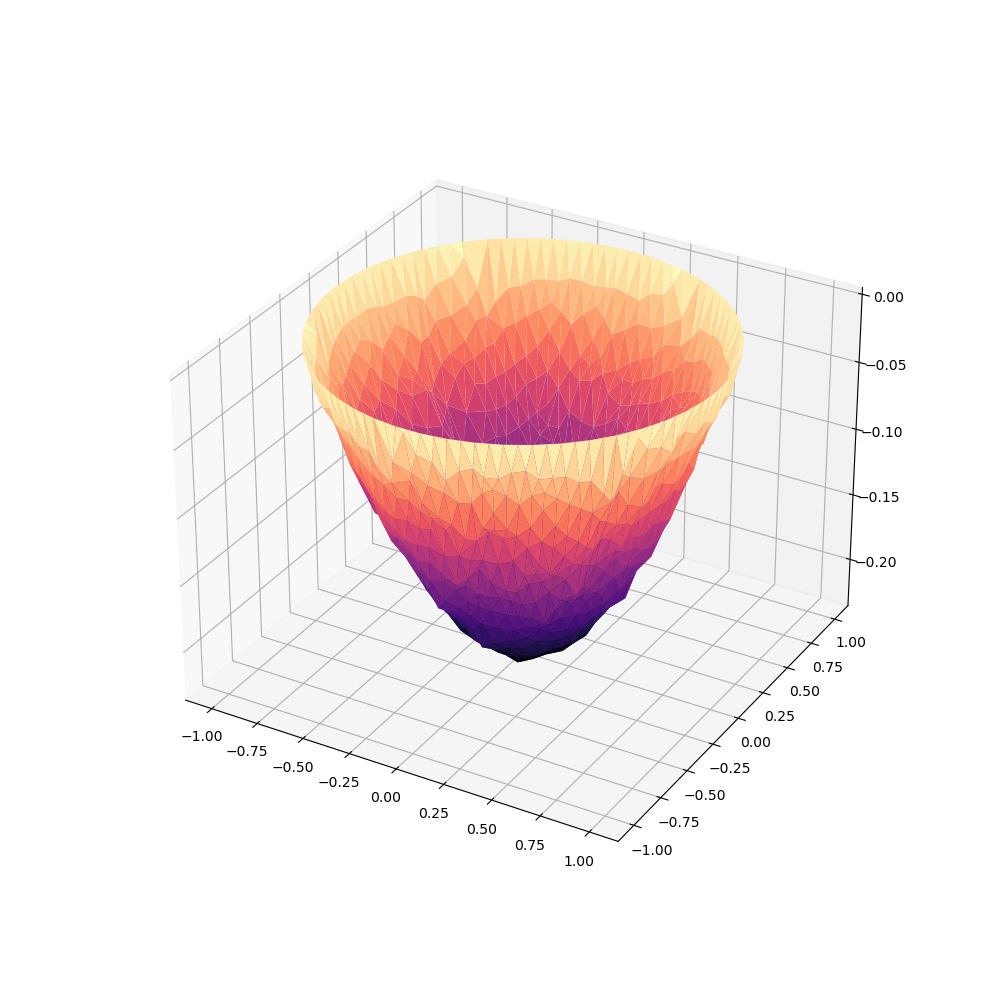

In [8]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
orig = (points[:, 0]**2+points[:, 1]**2-1)/4
ax.plot_trisurf(points[:, 0], points[:, 1], c, cmap='magma')
plt.show()